# Machine Learning on Big Data

# Problem Statement (Objective):
  Main objective is to configure a machine learning model that parses in a URL dataset with numerous columns that relate to each url and defines what values it has such as login or sensitive words, pre-process certain columns that may bias our model or flaw our LSEP principles, extract features based on relevancy between columns and each other, and relevancy between columns and target column. Optimize the learner, fine-tune, and visualize the results with appropriate metric calculations & plots.


# **Initiate and Configure Spark**

Initiating and configuring pypsark to build a sparksession instance.

In [ ]:
# add your code here
!pip install pyspark
from pyspark.sql import SparkSession as ss
spark = ss.builder.master("local[*]").getOrCreate()

---
# Data Loading and Preprocessing
---
Dataset Link: https://www.kaggle.com/datasets/pilarpieiro/tabular-dataset-ready-for-malicious-url-detection/data


Reading Malicious URL Dataset, figuring out what the are the columns inside this dataset. We can see that we have 60 columns in our dataset using the 'len' function and the attribute of '.columns' assigned to it, and 1160066 rows by configuring the same code to rows. We can see that we only have around 21% of instances that the label value is equal to 1 meaning that the url is malicious, this is important in hyper-tuning to assign weights to our learner

 Number of columns : 60
 Number of rows : 1160066


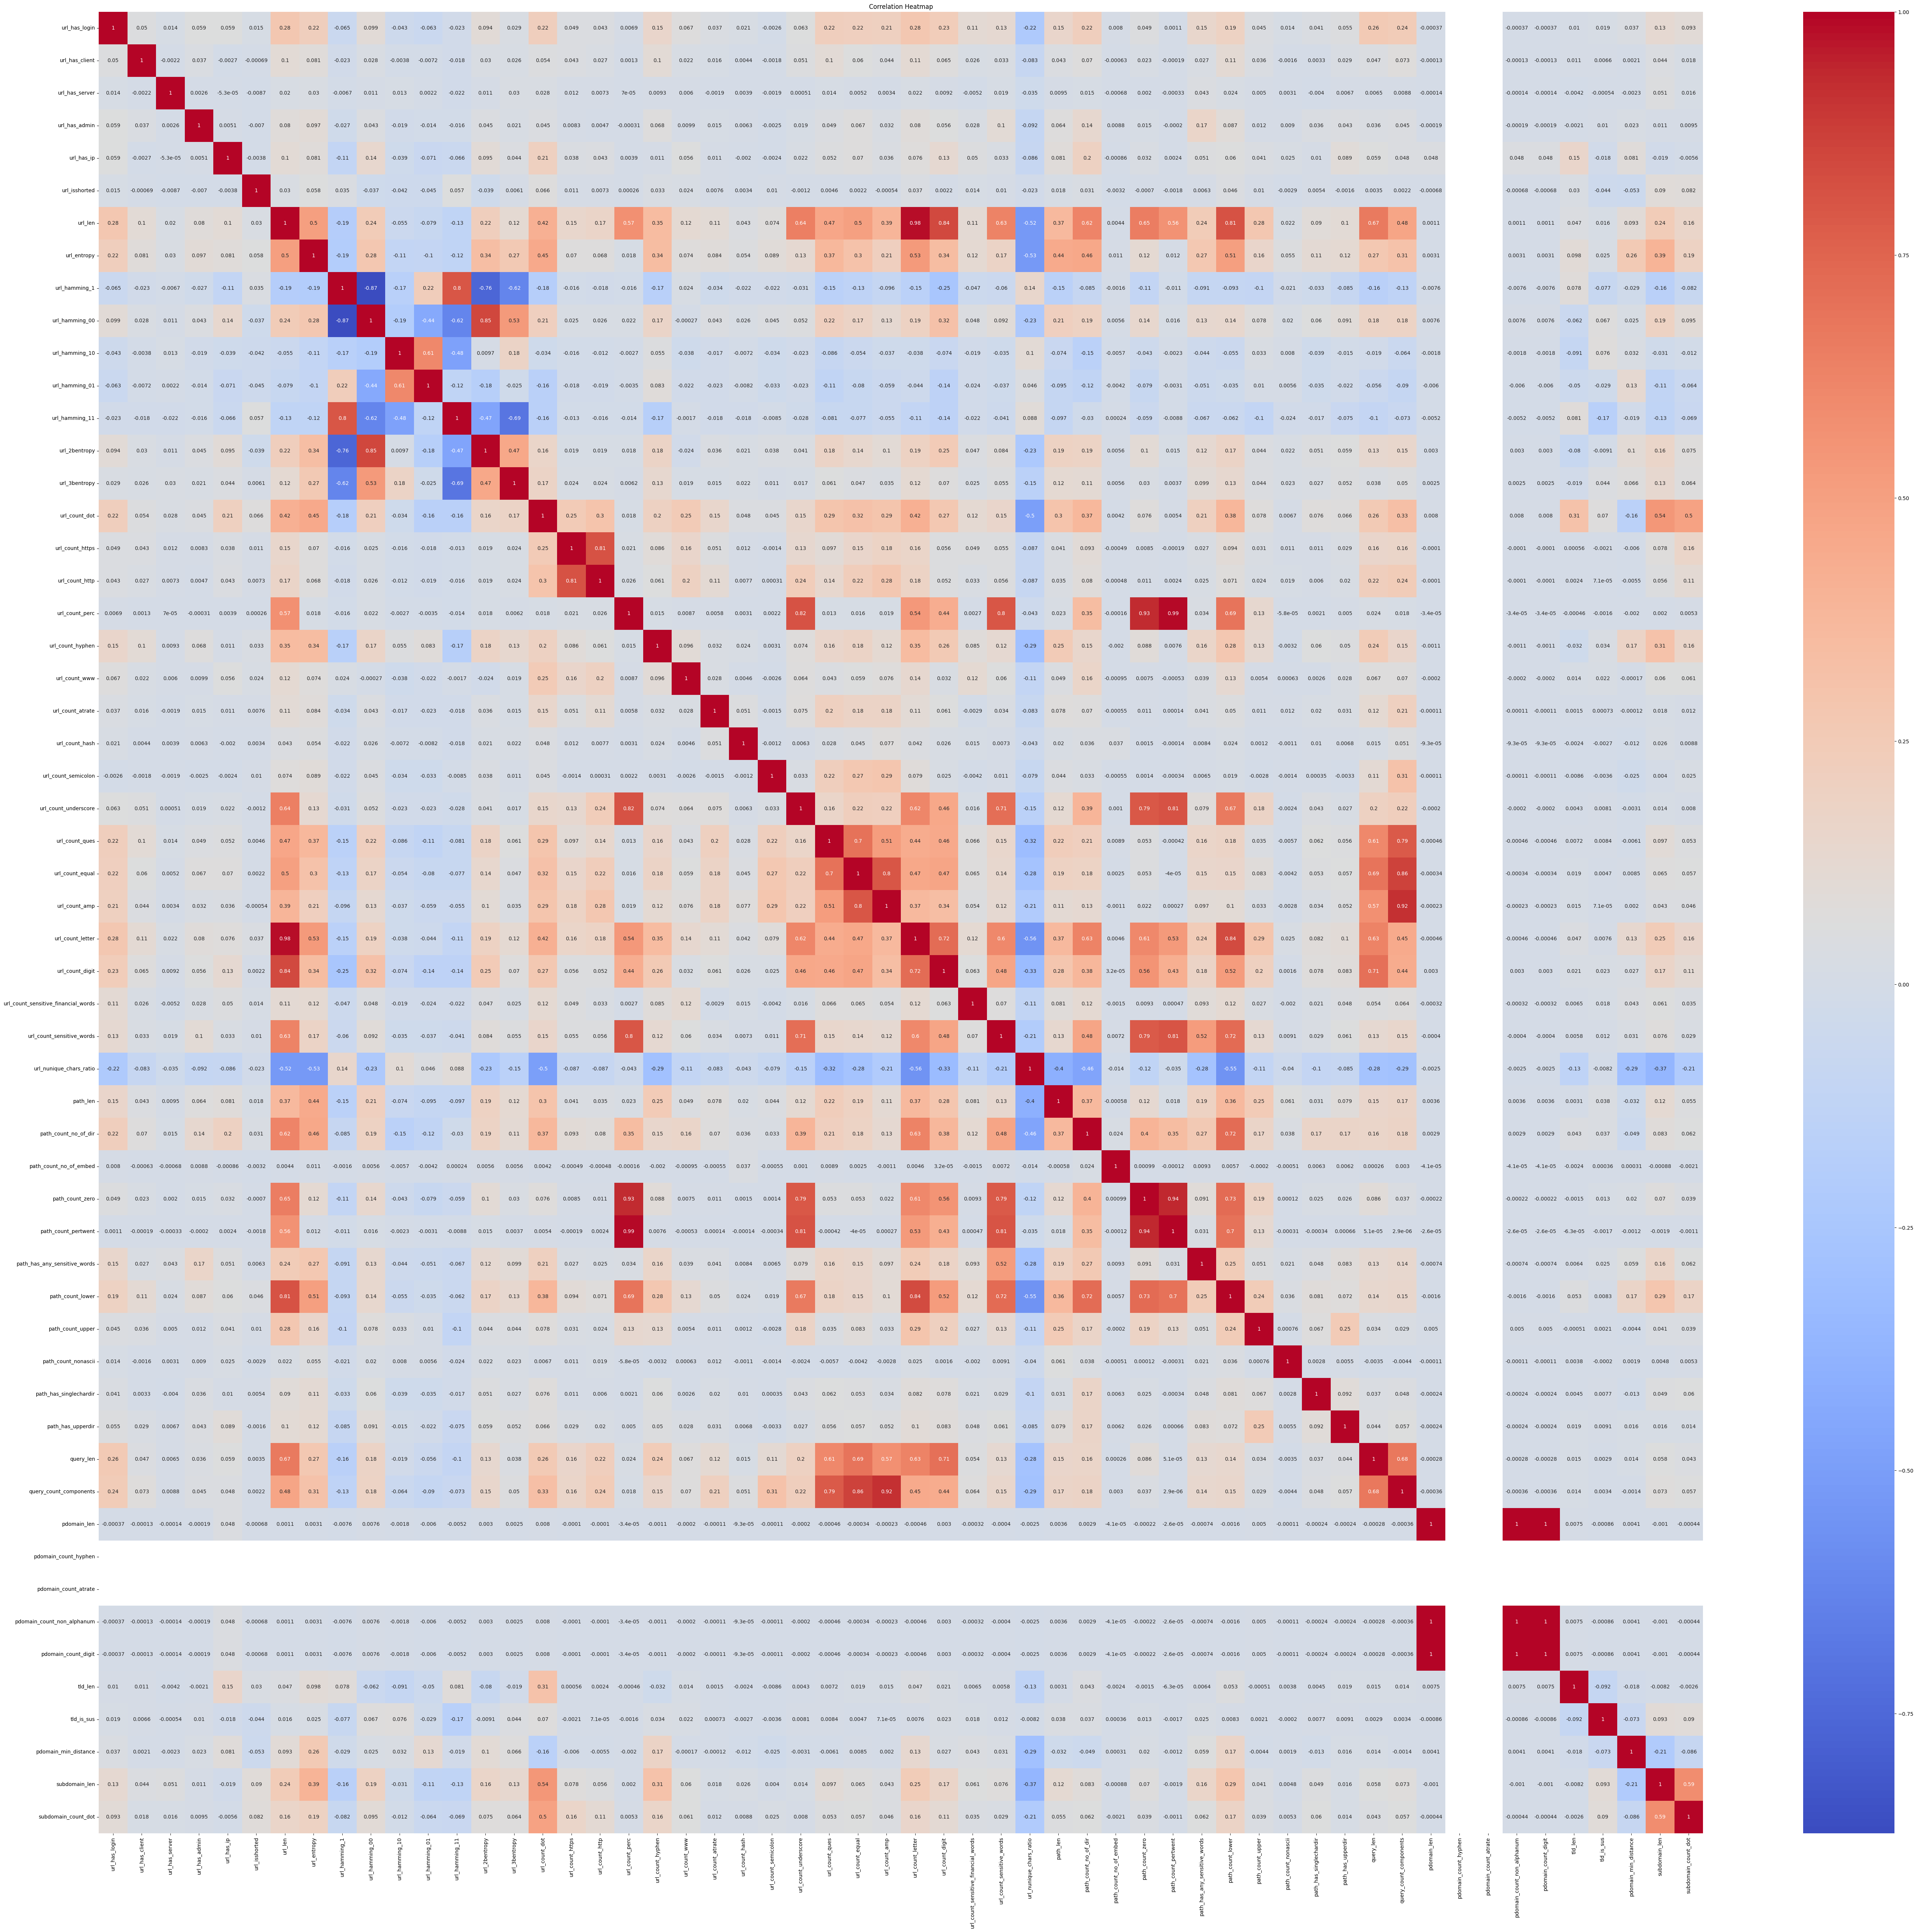

The total number of remaining columns is: 58


In [ ]:

mainDataset = spark.read.csv("/content/drive/MyDrive/ML&Big_Data/malicious_url.csv",inferSchema=True, header=True)
num_columns = len(mainDataset.columns)
print(" Number of columns :", num_columns)
num_rows = mainDataset.count()
print(" Number of rows :", num_rows)
import numpy as np
import seaborn as sns
import pandas as pd
#mainDataset.show(5)
import matplotlib.pyplot as plt # Importing matplotlibrary for figures, plots etc..
dataset_with_noStrings = mainDataset.drop("url","source","tld") # Drop the list of columns that contain strings.
#dataset_with_noStrings.show(5)
sample_dataset_with_noStrings = dataset_with_noStrings.sample(fraction=0.1, seed=60) # Sampling 10% out of entire dataset
pandasDataset = sample_dataset_with_noStrings.toPandas() # Converting sample dataset to Pandas dataframe
plt.figure(figsize=(70, 64)) # Figure Size
datasetHeatmap = pandasDataset.drop('label', axis=1)  # Dropping the label column to see correlation between columns.

sns.heatmap(datasetHeatmap.corr(), annot=True, cmap='coolwarm') #Seaborn Correlational Heatmap

plt.title('Correlation Heatmap')
plt.show()

cleanDataset = mainDataset.drop("pdomain_count_hyphen","pdomain_count_atrate") # dropping null columns based on heatmap
remainingNumberColumns = len(cleanDataset.columns) # Counting total number of remaining columns
print("The total number of remaining columns is:", remainingNumberColumns)

# 1st Heatmap Code & Figure Analysis
When trying to use a heatmap, I got a memory execution error, so I had to downsize my dataset to a sample of 10% to execute the following heatmap successfully. After sorting out this sampling error, I got an error for columns that have values of strings, so I dropped those 3 columns to create a new dataset with all numeric values. As these 3 columns ['url', 'source', 'tld'] are completely irrelevant to the objective of our model, they contain data like what is the url path, where was this url sourced from, and what is the top level domain for the url. Such features may actually bias the learning process as they can impact our LSEP practices and flaw the outcome. So, it was better to drop those columns rather than using string indexer to append them to our feature engineering prospective. Also, we can see that from the 1st heatmap,  that there are 2 columns have absolutely no relation to the rest of the columns ['pdomain_count_hyphen', 'pdomain_count_atrate'], so we can just drop those two when configuring our model to train. We'll try to configure new means of visualization to see what else has no impact on the 'label' so we can just drop those columns as well to save computational effort and cost.

# 2nd Heatmap Code & Figure Analysis
The second heatmap is for finding out which columns directly relate to the label column, this way while still using a simple binary classification model I was able to increase the AUROC from 85% on average to 88% average during multiple runs with varying samples of the test set and even running the whole test set has gotten 87.5% AUROC with the newly selected features.
Using this 2nd heatmap code we can see which columns have very limited or even negative impact on the 'label' column and just drop those columns as they would not be beneficial to have noisy data in the training model that does so little to affect the prediction.


# Feature Engineering


After a careful analysis of both the 1st heatmap and the 2nd heatmap, we combine the columns' values that can aid our model to accurately predict if a url is malicious or not, we import VectorAssembler library to construct an output column named "features" that has all the values of whatever columns we set as inputs, and we pass in the option 'handleInvalid' to either 'skip' or 'keep' as this option specified doesn't stop our model from completing the assembly process. The dataset is intended to have null values if a certain value of a column is not present in a row.

In [ ]:
from pyspark.ml.feature import VectorAssembler
# List of feature columns
selectedFeatures = ["url_has_login","url_len","url_entropy","url_hamming_00","url_count_dot","path_has_any_sensitive_words","url_count_letter","path_count_lower","path_len","path_count_no_of_dir","subdomain_len"]
# Initializing Assembler
vAssembler = VectorAssembler(inputCols=selectedFeatures, outputCol="features", handleInvalid="skip") # Setting handleIvalid to skip, otherwise we get an error when training.
featuresDataset = vAssembler.transform(cleanDataset) # Transforming the dataset
featuresDataset.select("features").show(truncate=False) # Showing features column.
dfColumns = len(featuresDataset.columns) # Counting total number of columns.
print ("The remaining number of columns is:", dfColumns) # We can see that we correctly appended the features column into our new dataset.

+-------------------------------------------------------------------------------+
|features                                                                       |
+-------------------------------------------------------------------------------+
|(11,[1,2,3,4,6,7],[15.0,3.640223928941852,0.1416666666666666,1.0,13.0,13.0])   |
|(11,[1,2,3,4,6,7],[12.0,2.9182958340544887,0.1458333333333333,1.0,11.0,11.0])  |
|(11,[1,2,3,4,6,7],[12.0,2.9182958340544887,0.0729166666666666,2.0,10.0,10.0])  |
|[0.0,15.0,3.640223928941851,0.0916666666666666,1.0,0.0,13.0,13.0,0.0,1.0,0.0]  |
|[0.0,29.0,3.9353986674667634,0.0948275862068965,2.0,0.0,25.0,25.0,0.0,0.0,14.0]|
|(11,[1,2,3,4,6,7],[21.0,3.916126946588284,0.0952380952380952,1.0,20.0,20.0])   |
|[0.0,33.0,3.67587110545754,0.1212121212121212,2.0,0.0,31.0,31.0,0.0,0.0,15.0]  |
|[0.0,25.0,3.7190795706241735,0.095,3.0,0.0,22.0,22.0,0.0,0.0,9.0]              |
|[0.0,33.0,4.104407755459852,0.1098484848484848,2.0,0.0,28.0,28.0,8.0,3.0,3.0]  |
|[0.0,21.0,3.368

---
# **Model Selection and Implementation**
---


#Initial Model
I have chosen MLP (MultilayerPerceptron) Classifier as a classiification model for this assignment, initially I had decide to use GBT (Gradient Boosted Tree) but due to the flexibility and non linear approch of MLP i continued with it.

Following is the model implementation, where I have only used 10% of dataset as a sample data in order to reduce the computational complexity and is also helpful in feature selection, as this over all leads to a more efficient model training.

After this application I was gettting a very high bias towards one class due to a highly imbalanced data, to counter this I have manually sampled 50% of instances to each class and combined them both using .union function to create a balanced data and then trained the model on this balanced data.

Count of benign instances: 126772
Count of malicious instances: 140191


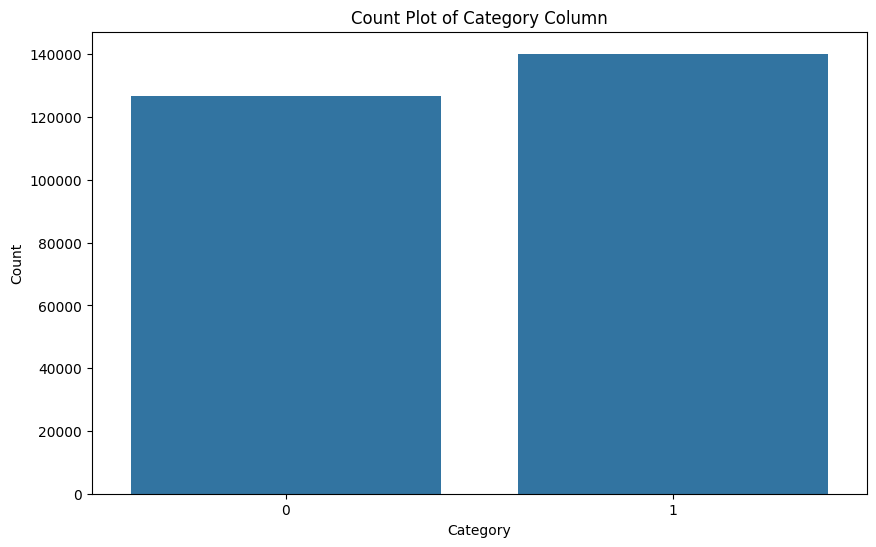

In [ ]:

from pyspark.ml.classification import MultilayerPerceptronClassifier #importing MLP classifier
from pyspark.sql.functions import col # importing col function for efficient and convenient column referencing


#featuresDataset_sample = featuresDataset.sample(fraction=0.99, seed=550) # Sampling the features dataset, 10%.
training_data, testing_data = featuresDataset.randomSplit([0.7, 0.3], seed=2500) # Split the dataset into train and test sets.


class_1 = training_data.filter(col("label") == 0) # Filtering all the rows with O in column 'label' and assigning the new dataframe to class_1
class_2 = training_data.filter(col("label") == 1) # Filtering all the rows with 1 in column 'label' and assigning the new dataframe to class_2

sampled_class_1 = class_1.sample(False, 0.2) # Sample 50% of class 1 instances

sampled_class_2 = class_2.sample(False, 0.8) # Sample 50% of class 2 instances

balanced_data = sampled_class_1.union(sampled_class_2) # Combine sampled instances to create the new balanced DataFrame



label_counts = balanced_data.groupBy('label').count().orderBy('label') # grouping data based on the values in 'label' and asssigning the df to label_counts

label_counts_list = label_counts.collect() # listing and gathering all the elements of label_counts

count_label_0 = label_counts_list[0]['count'] # list of all the instances of value "0"
count_label_1 = label_counts_list[1]['count'] # list of all the instances of value "0"

print("Count of benign instances:", count_label_0) # Print the number of all the 0 instances
print("Count of malicious instances:", count_label_1) # print the number of all the 1 instances

# EDA Count Plot
# Contribution of: Talha IJAZ
balanced_data_pd = balanced_data.toPandas()
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=balanced_data_pd)
plt.title('Count Plot of Category Column')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()





So after balancing the dataset, we can visualize it by creating a bar plot that has the categories values, and from the plot above we can see that we correctly balanced our dataset with the categories of "0", and "1".

---
# **Model Parameter Tuning**
---



I have used Hyperparameter tuning for the model for better accuracy and less computational time. Initially I have used solver and layers attributes to improve the accuracy. Initial runs had already improve the accuracy upto 86%. for further tuning I have decided to use "maxIter" and "Stepsize" in the grid. but addding these just increased the processing time by 20- 30 mins and also reduced the accuracy to 80-82%. which was not very efficient (for this specific model) and even added more complexity. So i decided to just stick with the original settings (.solver and .layers).

In [ ]:

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder # importing Crossvalidator and Pramgridbuilder functions


mpc =MultilayerPerceptronClassifier(featuresCol = 'features', labelCol = 'label') # assigning the feature and label column names to the classifier

grid = ParamGridBuilder().addGrid(mpc.solver,['gd','l-bfgs']).addGrid(mpc.layers, [[11, 2, 3, 2], [11, 4, 5, 2]]).build() # Setting up cross validation with grid search


# setting up Cross validator with parameter grid search
cv = CrossValidator(
                    estimator = mpc,
                    estimatorParamMaps = grid,
                    evaluator = MulticlassClassificationEvaluator(metricName="accuracy"),
                    parallelism = 2
                   )


---
# **Model Evaluation and Accuracy Calculation**
---


I have used the following code to evaluate the model and to get the metrics such as accuracy, precision, Recall and F-1 measure, I am getting 84-85% accuracy in this application.

I have decided to use the elaborated metrics to use them further in the visualisation part


Test set accuracy = 0.8488448370140593
              precision    recall  f1-score   support

           0       0.95      0.84      0.89    273077
           1       0.59      0.84      0.69     74509

    accuracy                           0.84    347586
   macro avg       0.77      0.84      0.79    347586
weighted avg       0.87      0.84      0.85    347586



/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8397835355854378
Precision: 0.5888255394664804
Recall: 0.8372008750620731
F1 measure: 0.6913830653876207


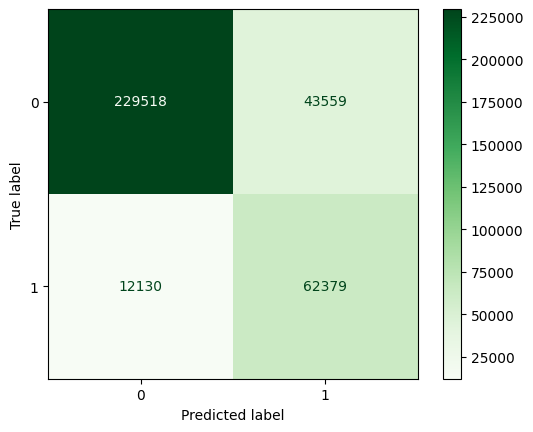

In [ ]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator # Importing evaluator
import sklearn # Importing scikit library sklearn
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cvModel = cv.fit(balanced_data) # Training the balanced dataframe
cvModel_preds = cvModel.transform(testing_data) #using .transform attribute to get the final predctions of dataset

evaluator = MulticlassClassificationEvaluator(labelCol = 'label') #defining evaluator with the target column 'label'
accuracy = evaluator.evaluate(cvModel_preds) # using .evaluate attribute to assess the performance of model by returning evaluation metrics
print("Test set accuracy = " + str(accuracy)) #prints accuracy


y_true = cvModel_preds.select(['label']).collect() # Collecting rows of labels values within predictions dataframe that was generated by the model.
y_pred = cvModel_preds.select(['prediction']).collect() # Collecting rows of predictions's values within predictions dataframe that was generated by the model.
print(classification_report(y_true, y_pred)) # Printing precision, recall, f1-score from scikit library.

prediction_array = np.array(y_pred) # Using .array function to change the class of predictions into an array.
label_array = np.array(y_true) # Using .array function to change the class of labels into an arrau.
cm = confusion_matrix(label_array, prediction_array) # Confusion Matrix
cm_display = ConfusionMatrixDisplay(cm).plot(cmap = 'Greens') # Displaying Confusion Matrix


# Convert DataFrame to RDD
prediction_and_label = cvModel_preds\
                        .select(["prediction", 'label'])\
                        .withColumn('label', col('label').cast(FloatType()))\
                        .orderBy('label')

metrics = MulticlassMetrics(prediction_and_label.rdd.map(tuple)) # Creates MulticlassMetrics object

# Printing metrics
print("Accuracy:", metrics.accuracy)
print("Precision:", metrics.precision(1.0))
print("Recall:", metrics.recall(1.0))
print("F1 measure:", metrics.fMeasure(1.0))




In the confusion matrix I have plotted the label data and prediction probability (to compare how accurate the model is while identifying the malicious and benign urls which are represented as 0 and 1)

---
# **Results Visualization or Printing**
---




For the Bar Plot I have again used the same data but it compares the accuracy of each label value (which means, how much accuracy does the model possess on one binary class over the other) and by the results we can tell that the model is highly accurate in identifying the malicious urls which are classed as 1 in this case (which is the whole point of this application )

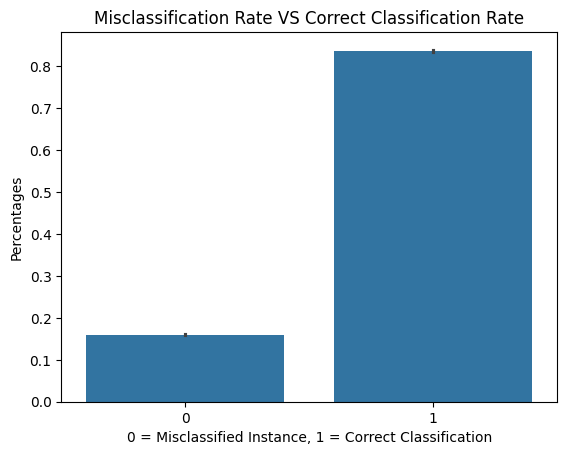

In [ ]:

import sklearn # Importing scikit library sklearn
from sklearn.metrics import classification_report #Importing classification report to summarise the metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix #Importing Confusion matrix visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#### Bar Plot Code Block #####

cvModel_preds_pandas = cvModel_preds.toPandas() #converting prediction dataset to pandas for visualisation
sns.barplot(x = ('label'), y = ('prediction') ,data = cvModel_preds_pandas) # defining values for Barplot based on the data

# Naming the X, Y axis nad plot title
plt.xlabel('0 = Misclassified Instance, 1 = Correct Classification')
plt.ylabel('Percentages')
plt.title('Misclassification Rate VS Correct Classification Rate')
plt.show() #present plot

---
# **LSEP Considerations**
---

#Talha IJAZ
For this coursework, I have used the dataset called “Tabular dataset ready for malicious URL detection” which was downloaded from Kaggle. We made sure to eliminate all the possible LSEP issues.

Since the dataset is publicly available, it makes It legal enough to be used for this project, I have still made sure that there are no legal restrictions by Kaggle’s legal terms.

Considering the social aspect, since this data is used to detect Malicious URL’s it can have online social safety and security concerns, considering this I have made sure to stick with the online safety and security terms so this cannot be abused and rather get used for a safer online environment.

Coming down to the Ethical aspect, this dataset does not contain any personal identifiable information, considering the potential abuse or consequences of this coursework I have made sure that there is no personal information or any identifiable information being used, there were few columns containing the URLs as strings which were eliminated during the pre-processing part to ensure the ethical use and to improve the overall performance by removing the potential bias of the model.

I ensured to be professional throughout the whole process of developing and executing this coursework so this do not fall into the wrong hands or be used for malignant purposes.

---

# **Convert ipynb to HTML**

---



In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/Machine_learning_on_Big_Data.ipynb'